# Perceptual decision-making and Psychophysics

如何用MCMC的方法估计weibull心理物理曲线的阈值

## Weibull psychometric function
Weibull函数为
$$
    y = 1 - (1-\gamma)\exp^{-(\frac{k*x}{\alpha})^\beta}
$$
其中
$$
k=-log(\frac{1-g}{1-\gamma})^{\frac{1}{\beta}}
$$


* $\alpha$为该正确率下的threshold
* $\beta$为函数的slope
* $\gamma$为基线chance level的概率值(这里我们固定为0.5)
* * $g$ 为threshold对应的正确率(这里我们固定为0.82)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 先定义weibull函数
def weibullfun(x, alpha, beta, gamma, g):
    k = (-np.log((1-g)/(1-gamma)))**(1/beta)
    y = 1 - (1 - gamma)*np.exp(-(k*x/alpha) ** beta) # hack here to avoid the complex number of 
    return y

Text(0, 0.5, 'Prob of correct')

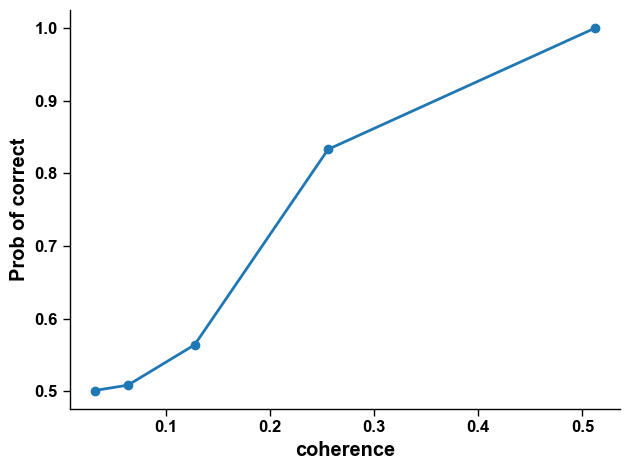

In [2]:
from scipy.stats import bernoulli
coh = np.array([0.032, 0.064, 0.128, 0.256, 0.512]) # coherence level in literature

# 定义参数
g = 0.82
gamma = 0.5 # Baseline chance level
beta = 3. # slop steepness
alpha = 0.25 # coherence threshold corresponding to g

nTrialPerCoh = 1000 # how many trials per coh level

pCoh = weibullfun(coh, alpha, beta, gamma, g)

plt.plot(coh, pCoh, 'o-')
plt.xlabel('coherence')
plt.ylabel('Prob of correct')

In [3]:
data = np.empty((coh.size, nTrialPerCoh))
for iCoh in range(coh.size): # loop coherence level
    # use bernouli process to generate data
    data[iCoh, :] = bernoulli.rvs(pCoh[iCoh], size=nTrialPerCoh)

cohTrial = np.tile(coh[:, np.newaxis], (1, nTrialPerCoh)).flatten() #(5000, ) array
data = data.flatten() # (5000, ) array

* `cohTrial`是一个长度nTrialPerCoh x 5的数组，代表每个trial的coherence level
* `data`是一个长度nTrialPerCoh x 5的数组，代表每个trial被试做对(1)和做错(0)

这里我们只假定threshold $\alpha$是需要估计的自由参数

下面来负责写MCMC的部分了

这里要安装pymc和arviz两个包
https://www.pymc.io/projects/docs/en/latest/installation.html

这里需要单独创建一个pymc的conda环境

In [4]:
import pymc as pm
import arviz as az

nSample = 1000
nBurnin = 1000
nTotalSample = nSample + nBurnin
samples = []

# 我们固定几个参数值
g = 0.82
gamma = 0.5 # Baseline chance level
beta = 3. # slop steepness

# compute k outside the sampling
k = (-np.log((1-g)/(1-gamma)))**(1/beta)

下面是pymc的实现部分

In [5]:
with pm.Model() as model:
    # 指定要求的参数alpha的prior分布为HalfNormal
    alpha = pm.HalfNormal('threshold', sigma=2)

    # weibull function
    prob = 1 - (1 - gamma)*pm.math.exp(-(k * cohTrial /alpha) ** beta) # hack here to avoid the complex number of 
    
    choice = pm.Bernoulli('choice', p=prob, observed=data) 

测试该model可以成功built
在model里面可以用 print(prob.shape), print(prob)这些东西来debug

In [6]:
with model:
    trace = pm.sample(draws=nSample, tune=nBurnin, chains=4)
    pm.compute_log_likelihood(trace) # calculate elementwise log likelihood 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [threshold]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


array([[<AxesSubplot: title={'center': 'threshold'}>,
        <AxesSubplot: title={'center': 'threshold'}>]], dtype=object)

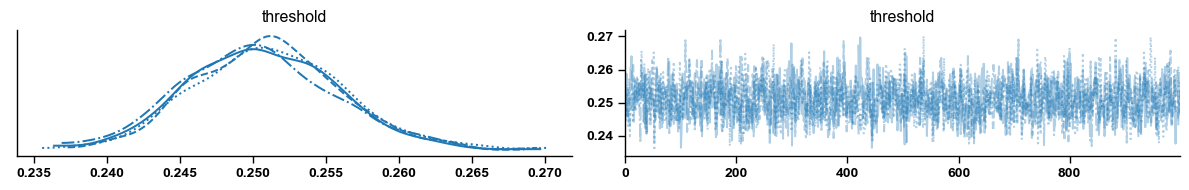

In [7]:
az.plot_trace(trace)

In [14]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

(array([3.000e+00, 4.000e+01, 2.420e+02, 8.540e+02, 1.256e+03, 9.540e+02,
        4.770e+02, 1.460e+02, 2.700e+01, 1.000e+00]),
 array([0.23590843, 0.24011982, 0.24433121, 0.24854261, 0.252754  ,
        0.25696539, 0.26117678, 0.26538818, 0.26959957, 0.27381096,
        0.27802236]),
 <BarContainer object of 10 artists>)

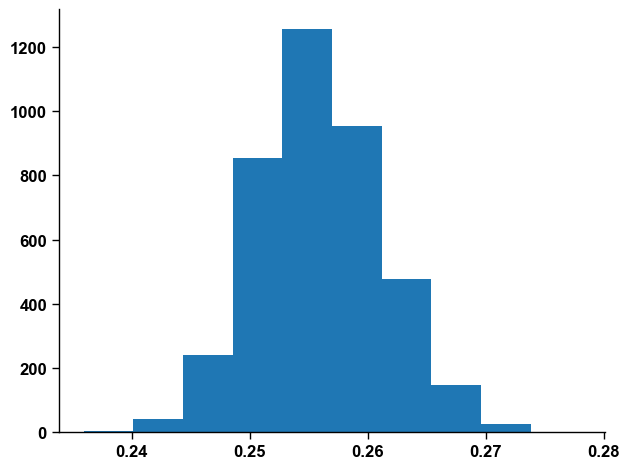

In [15]:
samples = np.array(trace['posterior']['threshold']) # get sample
plt.hist(samples.flatten())

In [16]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold,0.256,0.005,0.246,0.266,0.0,0.0,2014.0,2661.0,1.0
